In [82]:
!python -m pip install chess
!python -m pip install -U tensorboard

/home/calum/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:10: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, connect_and_authenticate
/home/calum/anaconda3/lib/python3.8/site-packages/secretstorage/__init__.py:10: UserWarning: jeepney.integrate.blocking is deprecated: please use jeepney.io.blocking instead.
  from jeepney.integrate.blocking import DBusConnection, connect_and_authenticate


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from aruco import *
from label import *

In [70]:
import os
import math
import tempfile
from tqdm import trange
from datetime import datetime
from itertools import chain
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image, write_jpeg

In [4]:
train_games = [
#     Game("Adams", 0),
    Game("Adams", 1),
    Game("Adams", 2),
    Game("Adams", 3),
]

test_games = [
    Game("Bird", 2)
]

In [5]:
len(test_games[0])

93

In [6]:
train_dir = save_games(train_games)
test_dir = save_games(test_games)
train_dir, test_dir

('/tmp/chess-vision-qokzd84y', '/tmp/chess-vision-nriy42ot')

In [22]:
class ChessFolder(datasets.ImageFolder):
    def _find_classes(self, dir):
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        return classes, {i: int(i) for i in classes}

In [72]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

data_transform = transforms.Compose([
    transforms.Resize(48),
#     transforms.Grayscale(),
#         transforms.RandomSizedCrop(224),
#         transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                              std=[0.229, 0.224, 0.225])
])


chess_datasets = {'train': ChessFolder(root=train_dir, transform=data_transform),
                  'val'  : ChessFolder(root=test_dir, transform=data_transform)}

dataloaders = {'train': DataLoader(chess_datasets['train'], shuffle=True, batch_size=4, num_workers=4),
               'val': DataLoader(chess_datasets['val'], batch_size=50, num_workers=4)}

dataset_sizes = {x: len(chess_datasets[x]) for x in ['train', 'val']}
labels_dict = {hash(label): label for label in LABELS}

cpu


In [24]:
dataset_sizes

{'train': 252, 'val': 93}

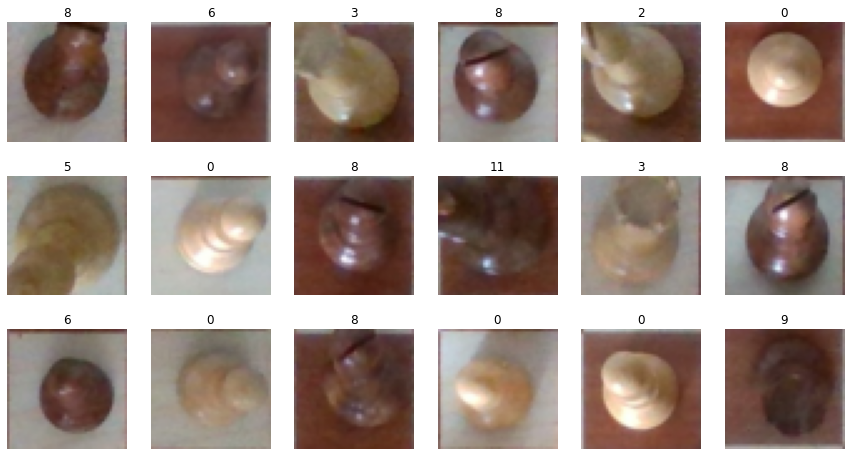

In [25]:
figure = plt.figure(figsize=(15, 8))
cols, rows = 6, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(dataset_sizes['val'], size=(1,)).item()
    img, label = chess_datasets['val'][sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0).squeeze(), cmap="gray")
plt.show()

In [26]:
class LeNet(nn.Module):
    def __init__(self, channels, classes):
        super(LeNet, self).__init__()
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=20, kernel_size=(5, 5))
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))

        self.fc0 = nn.Linear(in_features=6912, out_features=800)
        self.fc1 = nn.Linear(in_features=800, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
#         x = self.maxpool(self.relu(self.conv1(x)))
#         x = self.maxpool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return self.logSoftmax(x)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet(3, len(LABELS)).to(device)
torch.cuda.is_available()

False

In [87]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [88]:
def train_one_epoch(epoch_index):
    running_loss = 0

    for i, (x, y) in enumerate(dataloaders['train']):
        optimizer.zero_grad()

        loss = loss_fn(model(x), y)
        loss.backward()
        running_loss += loss.item()

        optimizer.step()
        
        if i % BS == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.
        
    return running_loss / i

In [35]:
writer = SummaryWriter(f"runs/chess-vision_{datetime.now().strftime('%Y%m%d_%H%M%S')}")

In [89]:
# TODO(torch.save)

EPOCHS = 300

for epoch in (t := trange(EPOCHS)):
    model.train(True)
    avg_loss = train_one_epoch(epoch)

    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(dataloaders['val']):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    t.set_description(f'LOSS: train {avg_loss:.3f} valid {avg_vloss:.3f}')
    
    writer.add_scalars('LOSS',
                    {'Training': avg_loss, 'Validation': avg_vloss},
                    epoch + 1)
    writer.flush()

LOSS: train 2.273 valid 2.236:   1%|        | 4/300 [00:09<12:01,  2.44s/it]


KeyboardInterrupt: 

In [90]:
def accuracy():
    correct = 0
    for x, y in chess_datasets['val']:
        correct += (model(x.unsqueeze(0)).argmax() == y).sum().item()
    return correct/len(chess_datasets['val'])*100

accuracy = accuracy()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 31.18


In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def create_confusion_matrix(loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        output = model(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    return confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cf_values):
    classes = [piece.unicode_symbol() for piece in LABELS]
    cf_weight = cf_values / cf_values.sum(axis=1)
    plt.figure(figsize=(12, 12))
    sn.set(font_scale=1.5)
    cf = sn.heatmap(pd.DataFrame(cf_weight, index=classes, columns=classes), annot=cf_values, cbar=False, cmap="Blues")
    cf.set_xticklabels(cf.get_xmajorticklabels(), fontsize=40)
    cf.set_yticklabels(cf.get_ymajorticklabels(), fontsize=40)
    cf.set_ylabel('Ground Truth')
    cf.set_xlabel('Predicted')
    return cf.get_figure()

In [96]:
cf_matrix = create_confusion_matrix(dataloaders['train'])
writer.add_figure("Confusion Matrix", plot_confusion_matrix(cf_matrix), epoch)

In [98]:
## TODO
#
# 
writer.add_hparams(
    {'loss_fn': repr(loss_fn), 'optimizer': repr(optimizer), 'model': repr(model)}, 
    {'accuracy': accuracy}
)

In [84]:
repr(model)

'LeNet(\n  (relu): ReLU()\n  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)\n  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1))\n  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))\n  (fc0): Linear(in_features=6912, out_features=800, bias=True)\n  (fc1): Linear(in_features=800, out_features=500, bias=True)\n  (fc2): Linear(in_features=500, out_features=12, bias=True)\n  (logSoftmax): LogSoftmax(dim=1)\n)'

In [83]:
writer.add_graph(model, input_to_model=next(iter(dataloaders['train'])))

TypeError: forward() takes 2 positional arguments but 3 were given

In [ ]:
writer.close()